In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import scipy.io
import scipy as sp
from scipy import signal

In [2]:
# function to calculate A and B from the dataset
def OUanalytic(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult(data,deltat):
    A, dA, B ,dB = OUanalytic(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

(374,)


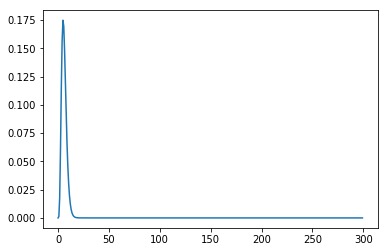

In [3]:
# lets model the hemodynamic response function
# SPM uses a double Gamma function
# scipy.stats.gamma(x,a,loc,scale) where a is alpha and 1/scale is beta
tHDRF = np.arange(0,374*0.802,0.802)
hdrf = sp.stats.gamma.pdf(tHDRF,6)#-sp.stats.gamma.pdf(tHDRF,16)/6.0
plt.plot(tHDRF,hdrf)
print(hdrf.shape)

In [4]:
oxy_sub6=scipy.io.loadmat('Resting/subject6.mat')
oxy_sub6

{'__header__': b'MATLAB 5.0 MAT-file Platform: posix, Created on: Sun Dec 30 10:08:05 2018',
 '__version__': '1.0',
 '__globals__': [],
 'voxelwise_ts_LLP': array([[-6.8011918e-06, -7.1218001e-06, -1.3510463e-05, ...,
         -1.7279640e-11, -9.0759485e-13,  2.9593857e-05],
        [-6.8011886e-06, -7.1218019e-06, -1.3510463e-05, ...,
         -4.5471695e-12,  4.5322746e-13,  2.9593866e-05],
        [-6.8011900e-06, -7.1217942e-06, -1.3510461e-05, ...,
          1.1396041e-12,  5.4584883e-12,  2.9593870e-05],
        ...,
        [-1.1439236e+01, -1.0794755e+01, -9.5949516e+00, ...,
         -3.4768960e+00, -6.4276171e+00, -1.0477752e+01],
        [-6.3935795e+00, -5.9913530e+00, -4.4400401e+00, ...,
         -2.4562533e+00, -3.6752930e+00, -4.2305326e+00],
        [-5.4842477e+00, -2.7001746e+00, -3.8621869e+00, ...,
         -7.1245146e+00, -7.2544637e+00, -8.4036074e+00]], dtype=float32),
 'voxelwise_ts_mPFC': array([[-8.6386037e-12, -5.7724296e-06,  6.8212103e-13, ...,
         -7

In [5]:
llp_all = oxy_sub6['voxelwise_ts_LLP']
mpfc_all = oxy_sub6['voxelwise_ts_mPFC']
pcc_all = oxy_sub6['voxelwise_ts_PCC']
rlp_all = oxy_sub6['voxelwise_ts_RLP']

<ErrorbarContainer object of 3 artists>

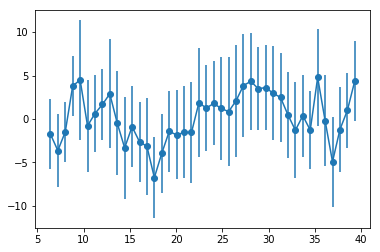

In [22]:
llp = np.mean(llp_all,axis=1)
mpfc = np.mean(mpfc_all,axis=1)
pcc = np.mean(pcc_all,axis=1)
rlp = np.mean(rlp_all,axis=1)
t_llp = np.arange(len(llp))*0.802 # tR = 0.802 sec
llp_std = np.std(llp_all,axis=1)
dis = 50
plt.errorbar(t_llp[8:dis],llp[8:dis],yerr=llp_std[8:dis],fmt="o-")

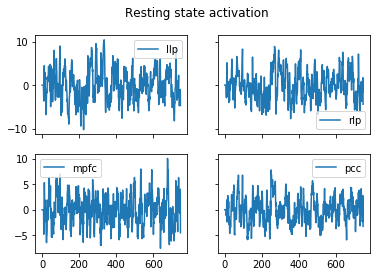

In [23]:
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex='col', sharey='row')
f.suptitle('Resting state activation')
ax1.plot(llp, label="llp")
ax1.legend()
ax2.plot(rlp,label = "rlp")
ax2.legend()
ax3.plot(mpfc,label = "mpfc")
ax3.legend()
ax4.plot(pcc,label = "pcc")
ax4.legend()

mean:  0.00097245583
var:  8.08861593914395
N:  748
relaxation time: 1.9951858231205215 SD tau 0.20166940034528796
A  8.093032341737148 SD A 0.6769352446395173


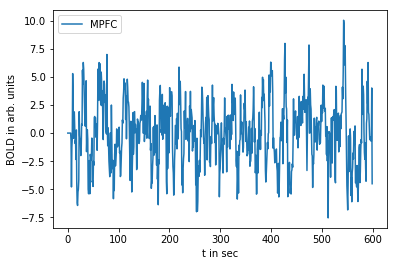

In [24]:
print("mean: ",mpfc.mean())
print("var: ",mpfc.std()**2)
N=len(mpfc)
print("N: ",N)
mpfc_A,mpfc_sA, mpfc_tau, mpfc_dtau = OUresult(mpfc,0.802)
print("relaxation time:",mpfc_tau, "SD tau", mpfc_dtau)
print("A ",mpfc_A,"SD A",mpfc_sA)
mpfc_norm=mpfc/np.sqrt(mpfc_A)
t = np.arange(N)*0.802 # tR = 0.802 sec
plt.plot(t,mpfc,label="MPFC")
plt.xlabel("t in sec")
plt.ylabel("BOLD in arb. units")
plt.legend()

/Users/hstrey/anaconda3/lib/python3.6/site-packages/mkl_fft/_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


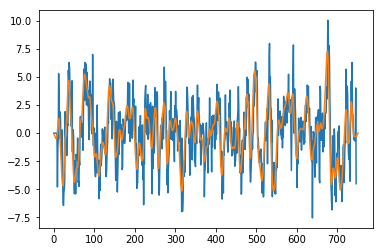

In [25]:
mpfc_pure = signal.fftconvolve(mpfc, hdrf[::-1], mode='full')
plt.plot(mpfc)
plt.plot(mpfc_pure[368:])

mean:  -0.027104653
var:  5.889963526192332
N:  748
relaxation time: 3.7947688015249335 SD tau 0.4751009394264947
A  5.887745400853813 SD A 0.6652528001952436
1.0001884


Text(0,0.5,'BOLD in arb. units')

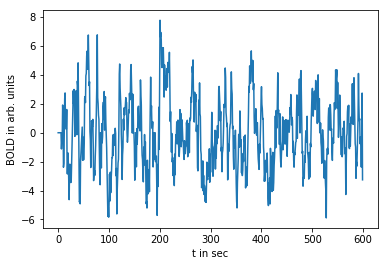

In [26]:
print("mean: ",pcc.mean())
print("var: ",pcc.std()**2)
N=len(pcc)
print("N: ",N)
pcc_A,pcc_sA, pcc_tau, pcc_dtau = OUresult(pcc,0.802)
print("relaxation time:",pcc_tau, "SD tau", pcc_dtau)
print("A ",pcc_A,"SD A",pcc_sA)
pcc_norm=pcc/np.sqrt(pcc_A)
print(pcc_norm.std())
plt.plot(t,pcc)
plt.xlabel("t in sec")
plt.ylabel("BOLD in arb. units")

mean:  -0.046775527
var:  10.06984063247387
N:  748
relaxation time: 3.9968969749785512 SD tau 0.5106431049905588
A  10.06925913372594 SD A 1.1667543698318759
1.0000288


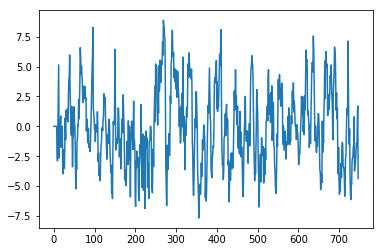

In [27]:
plt.plot(rlp)
print("mean: ",rlp.mean())
print("var: ",rlp.std()**2)
N=len(rlp)
print("N: ",N)
rlp_A,rlp_sA, rlp_tau, rlp_dtau = OUresult(rlp,0.802)
print("relaxation time:",rlp_tau, "SD tau", rlp_dtau)
print("A ",rlp_A,"SD A",rlp_sA)
rlp_norm=rlp/np.sqrt(rlp_A)
print(rlp_norm.std())

mean:  -0.02714433
var:  11.865867767715827
N:  748
relaxation time: 3.6234519413485526 SD tau 0.4457655046622676
A  11.861770138633412 SD A 1.3108301308487396
1.0001726


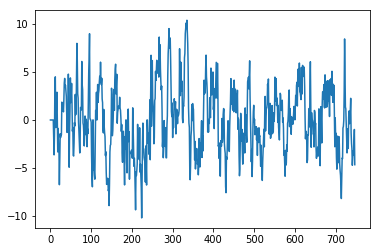

In [28]:
plt.plot(llp)
print("mean: ",llp.mean())
print("var: ",llp.std()**2)
N=len(llp)
print("N: ",N)
llp_A,llp_sA, llp_tau, llp_dtau = OUresult(llp,0.802)
print("relaxation time:",llp_tau, "SD tau", llp_dtau)
print("A ",llp_A,"SD A",llp_sA)
llp_norm=llp/np.sqrt(llp_A)
print(llp_norm.std())

{'whiskers': [<matplotlib.lines.Line2D at 0x1c25041588>,
 'caps': [<matplotlib.lines.Line2D at 0x1c25041e48>,
 'boxes': [<matplotlib.lines.Line2D at 0x1c25041438>],
 'medians': [<matplotlib.lines.Line2D at 0x1c250a66d8>],
 'fliers': [<matplotlib.lines.Line2D at 0x1c250a6b00>],
 'means': []}

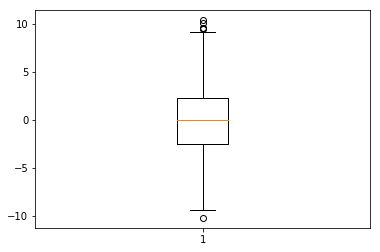

In [29]:
plt.boxplot(llp)

In [30]:
def OUcross(data1,data2):
    x1 = data1 + data2
    x2 = data1 - data2
    x1_A,x1_dA, x1_tau ,x1_dtau= OUresult(x1,0.802)
    x2_A, x2_dA, x2_tau ,x2_dtau= OUresult(x2,0.802)
    return (x1_A - x2_A)/x2_A, np.sqrt(x1_dA**2 + x1_A**2*x2_dA**2/x2_A**4)
print("MPFC:PCC",OUcross(mpfc_norm,pcc_norm))
print("MPFC:RLP",OUcross(mpfc_norm,rlp_norm))
print("MPFC:LLP",OUcross(mpfc_norm,llp_norm))
print("PCC:RLP",OUcross(pcc_norm,rlp_norm))
print("PCC:LLP",OUcross(pcc_norm,llp_norm))
print("RLP:LLP",OUcross(rlp_norm,llp_norm))
print("Pearson MPFC:PCC",sp.stats.pearsonr(mpfc_norm,pcc_norm))
print("Pearson MPFC:RLP",sp.stats.pearsonr(mpfc_norm,rlp_norm))
print("Pearson MPFC:LLP",sp.stats.pearsonr(mpfc_norm,llp_norm))
print("Pearson PCC:RLP",sp.stats.pearsonr(pcc_norm,rlp_norm))
print("Pearson PCC:LLP",sp.stats.pearsonr(pcc_norm,llp_norm))
print("Pearson RLP:LLP",sp.stats.pearsonr(rlp_norm,llp_norm))

MPFC:PCC (1.0348454679956045, 0.3322028025978507)
MPFC:RLP (0.6498415280612885, 0.28743034916345317)
MPFC:LLP (0.28731646158836066, 0.24069373502594468)
PCC:RLP (1.7932523291811473, 0.4815989741444286)
PCC:LLP (1.1917197457589837, 0.4450688003477857)
RLP:LLP (5.649275929489535, 0.7872683896336239)
Pearson MPFC:PCC (0.33806917, 1.8691251244612773e-21)
Pearson MPFC:RLP (0.24216129, 1.9185997811410534e-11)
Pearson MPFC:LLP (0.12191682, 0.000833960522958876)
Pearson PCC:RLP (0.4695297, 2.8044428073923486e-42)
Pearson PCC:LLP (0.36774948, 2.2821919559641497e-25)
Pearson RLP:LLP (0.73755, 2.501081452590018e-129)


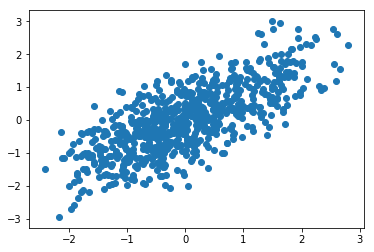

In [31]:
plt.scatter(rlp_norm,llp_norm)

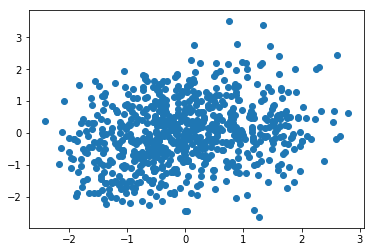

In [32]:
plt.scatter(rlp_norm,mpfc_norm)

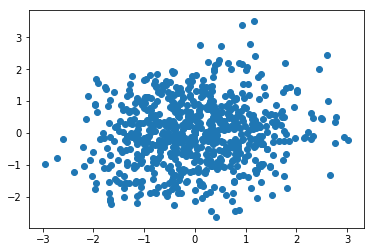

In [33]:
plt.scatter(llp_norm,mpfc_norm)

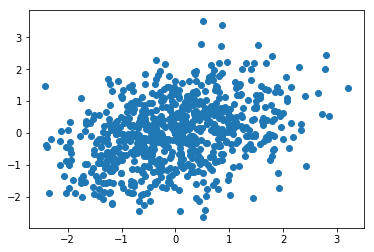

In [34]:
plt.scatter(pcc_norm,mpfc_norm)